# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from binomial import *

In [2]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree

time $t$,0,0.5
node,,
0,0.0174,0.0339
1,NaN,0.0095


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [3]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct

,price,continuous ytm
maturity,,
0.5,99.1338,0.017399
1.0,97.8925,0.021300
1.5,96.1462,0.026200


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

----

## 1.1

In [4]:
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)
bond_tree.iloc[0,0] = term_struct.loc[1,'price']
bond_tree['0.5'] = np.exp(- rate_tree['0.5'] * 0.5) * 100
bond_tree

time $t$,0,0.5
node,,
0,97.8925,98.319284
1,NaN,99.526126


## 1.2

In [5]:
A = np.exp(rate_tree.iloc[0,0] * 0.5)
u = bond_tree.loc[0,'0.5']
d = bond_tree.loc[1,'0.5']
c = bond_tree.loc[0, '0']
pstar = (A * c - d) / (u - d)
pstar

0.6448615964742744

## 1.3

In [6]:
payoff = lambda r: 100/2 * (r - 0.02)
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns)
swap_tree['0.5'] = payoff(rate_tree['0.5'])
swap_tree

time $t$,0,0.5
node,,
0,NaN,0.695
1,NaN,-0.525


In [7]:
rep_port = replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, swap_tree, dt='0.5')
rep_port

,positions,value
cash,1.000862,99.13380
under,-1.010903,97.89250
derivative,NaN,0.25949


Here, under means the underlying, which is the bond.

## 1.4

In [8]:
Z = np.exp(-rate_tree.iloc[0,0] * 0.5)
swap_tree.loc[0,'0'] = Z * np.array([pstar,1-pstar]) @ swap_tree['0.5'].values
swap_tree

time $t$,0,0.5
node,,
0,0.259464,0.695
1,NaN,-0.525


---

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

---

## 2.1

In [9]:
swap_tree

time $t$,0,0.5
node,,
0,0.259464,0.695
1,NaN,-0.525


## 2.2

In [10]:
A = np.exp(rate_tree.iloc[0,0] * 0.5)
u = swap_tree.loc[0,'0.5']
d = swap_tree.loc[1,'0.5']
c = swap_tree.loc[0, '0']
pstar = (A * c - d) / (u - d)
pstar

0.6448615964742744

This is the same risk-neutral probability we found when the bond was the underlying.

## 2.3

In [11]:
payoff = lambda r: 100 * np.maximum(0.02 - r,0)

floorlet_tree = pd.DataFrame(columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree['0.5'] = payoff(rate_tree['0.5'])
floorlet_tree.loc[0,'0'] = Z * np.array([pstar, 1-pstar])@floorlet_tree['0.5']
floorlet_tree

time $t$,0,0.5
node,,
0,0.369665,0.00
1,NaN,1.05


The value of 0.3696 matches what was calculated in note W.1.

---

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

---

## 3.1

In [12]:
payoff = lambda p: np.maximum(p-99, 0)
rate_tree.columns = [float(i) for i in rate_tree.columns]
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
bond_tree.columns = [float(i) for i in bond_tree.columns]
derivtree = bintree_pricing(payoff, rate_tree, undertree=bond_tree, pstars=pstars)
derivtree

,0.0,0.5
node,,
0,0.185229,0.000000
1,NaN,0.526126


In [13]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, derivtree, dt=.5)

,positions,value
cash,-0.428626,99.133800
under,0.435953,97.892500
derivative,NaN,0.185218


## 3.2

In [14]:
derivtree.loc[0, 0]

0.18522914483722105

---

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [15]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series([0,0.5,1],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi

time $t$,0.0,0.5,1.0
node,,,
0,0.0174,0.0339,0.0500
1,NaN,0.0095,0.0256
2,NaN,NaN,0.0011


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

---

## 4.1

In [16]:
pstars = estimate_pstar(term_struct,rate_tree_multi)
payoff = lambda r: payoff_bond(r,0.5)

bond_tree_multi = bintree_pricing(payoff, rate_tree_multi, pstars=pstars)
bond_tree_multi

time $t$,0.0,0.5,1.0
node,,,
0,96.1462,96.142586,97.530991
1,NaN,98.518379,98.728157
2,NaN,NaN,99.945015


## 4.2

In [17]:
A = np.exp(rate_tree_multi.loc[0,0.5] * 0.5)
u = bond_tree_multi.loc[0,1]
d = bond_tree_multi.loc[1,1]
c = bond_tree_multi.loc[0, 0.5]
pstar = (A * c - d) / (u - d)
pstar

0.7869126669821886

In [18]:
A = np.exp(rate_tree_multi.loc[1,0.5] * 0.5)
u = bond_tree_multi.loc[1,1]
d = bond_tree_multi.loc[2,1]
c = bond_tree_multi.loc[1, 0.5]
pstar = (A * c - d) / (u - d)
pstar

0.7869126669821899

## 4.3

In [19]:
# Assume strike of 99
payoff = lambda p: np.maximum(p-99,0)
derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars)
derivtree

time $t$,0.0,0.5,1.0
node,,,
0,0.070559,0.000000,0.000000
1,NaN,0.200417,0.000000
2,NaN,NaN,0.945015


In [20]:
derivtree.loc[0,0]

0.07055905721797212

## 4.4

In [21]:
# Use multiplicative approach

dt = 1/30
sigma = .30
up = np.exp(sigma*np.sqrt(dt))
down = np.exp(-sigma*np.sqrt(dt))
rate_tree_dense = construct_rate_tree(dt, 1.5-dt)
rate_tree_dense.loc[0, 0] = rate_tree_multi.loc[0, 0]

for tsteps in range(rate_tree_dense.shape[1]-1):
    rate_tree_dense.iloc[:,tsteps+1] = rate_tree_dense.iloc[:,tsteps] * up        
    rate_tree_dense.iloc[tsteps+1,tsteps+1] = rate_tree_dense.iloc[tsteps,tsteps] * down
    
rate_tree_dense

time,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,...,1.166667,1.200000,1.233333,1.266667,1.300000,1.333333,1.366667,1.400000,1.433333,1.466667
state,,,,,,,,,,,,,,,,,,,,,
0,0.0174,0.018380,0.019414,0.020507,0.021662,0.022882,0.024170,0.025531,0.026968,0.028486,...,0.118333,0.124995,0.132032,0.139465,0.147317,0.155611,0.164372,0.173626,0.183401,0.193727
1,NaN,0.016473,0.017400,0.018380,0.019414,0.020507,0.021662,0.022882,0.024170,0.025531,...,0.106055,0.112026,0.118333,0.124995,0.132032,0.139465,0.147317,0.155611,0.164372,0.173626
2,NaN,NaN,0.015595,0.016473,0.017400,0.018380,0.019414,0.020507,0.021662,0.022882,...,0.095051,0.100402,0.106055,0.112026,0.118333,0.124995,0.132032,0.139465,0.147317,0.155611
3,NaN,NaN,NaN,0.014763,0.015595,0.016473,0.017400,0.018380,0.019414,0.020507,...,0.085188,0.089985,0.095051,0.100402,0.106055,0.112026,0.118333,0.124995,0.132032,0.139465
4,NaN,NaN,NaN,NaN,0.013977,0.014763,0.015595,0.016473,0.017400,0.018380,...,0.076349,0.080648,0.085188,0.089985,0.095051,0.100402,0.106055,0.112026,0.118333,0.124995
5,NaN,NaN,NaN,NaN,NaN,0.013232,0.013977,0.014763,0.015595,0.016473,...,0.068428,0.072280,0.076349,0.080648,0.085188,0.089985,0.095051,0.100402,0.106055,0.112026
6,NaN,NaN,NaN,NaN,NaN,NaN,0.012526,0.013232,0.013977,0.014763,...,0.061328,0.064780,0.068428,0.072280,0.076349,0.080648,0.085188,0.089985,0.095051,0.100402
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011859,0.012526,0.013232,...,0.054965,0.058059,0.061328,0.064780,0.068428,0.072280,0.076349,0.080648,0.085188,0.089985
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011227,0.011859,...,0.049262,0.052035,0.054965,0.058059,0.061328,0.064780,0.068428,0.072280,0.076349,0.080648


In [22]:
pstars = pd.Series(.65, index=rate_tree_dense.columns, name='pstar')
payoff = lambda r: payoff_bond(r,dt)
bond_tree_dense = bintree_pricing(payoff, rate_tree_dense, pstars = pstars)
bond_tree_dense

time,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,...,1.166667,1.200000,1.233333,1.266667,1.300000,1.333333,1.366667,1.400000,1.433333,1.466667
state,,,,,,,,,,,,,,,,,,,,,
0,96.117927,96.032324,95.946819,95.861597,95.776857,95.692815,95.609710,95.527797,95.447355,95.368685,...,95.812393,96.050217,96.319842,96.623968,96.965524,97.347687,97.773914,98.247967,98.773946,99.356324
1,NaN,96.436230,96.359266,96.282550,96.206260,96.130595,96.055765,95.982003,95.909560,95.838708,...,96.238543,96.452625,96.695265,96.968864,97.276026,97.619571,98.002559,98.428315,98.900456,99.422917
2,NaN,NaN,96.730493,96.661465,96.592816,96.524723,96.457378,96.390988,96.325781,96.262002,...,96.622099,96.814723,97.032985,97.279026,97.555160,97.863892,98.207936,98.590233,99.013977,99.482639
3,NaN,NaN,NaN,97.002388,96.940640,96.879388,96.818804,96.759077,96.700409,96.643023,...,96.967167,97.140413,97.336672,97.557853,97.806015,98.083384,98.392370,98.735577,99.115831,99.536195
4,NaN,NaN,NaN,NaN,97.253484,97.198406,97.143927,97.090214,97.037451,96.985838,...,97.277488,97.433248,97.609662,97.808432,98.031392,98.280522,98.557962,98.866023,99.207205,99.584218
5,NaN,NaN,NaN,NaN,NaN,97.485254,97.436280,97.387993,97.340558,97.294154,...,97.556461,97.696454,97.854982,98.033561,98.233828,98.457543,98.706610,98.983080,99.289170,99.627278
6,NaN,NaN,NaN,NaN,NaN,NaN,97.699078,97.655682,97.613051,97.571344,...,97.807173,97.932959,98.075375,98.235774,98.415616,98.616469,98.840026,99.088110,99.362689,99.665886
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.896246,97.857942,97.820468,...,98.032424,98.145415,98.273324,98.417362,98.578829,98.759124,98.959752,99.182337,99.428625,99.700501
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.077966,98.044304,...,98.234748,98.336221,98.451077,98.580396,98.725338,98.887153,99.067180,99.266864,99.487758,99.731535


In [23]:
payoff = lambda p: np.maximum(p - 99,0)
ratetreeT = rate_tree_dense.loc[:,:1].dropna(axis=0,how='all')
bondtreeT = bond_tree_dense.loc[:,:1].dropna(axis=0,how='all')
derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars)
derivtree

time,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,...,0.700000,0.733333,0.766667,0.800000,0.833333,0.866667,0.900000,0.933333,0.966667,1.000000
state,,,,,,,,,,,,,,,,,,,,,
0,0.005688,0.003843,0.002506,0.001570,0.000940,0.000535,0.000288,0.000144,0.000067,0.000028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,0.009124,0.006333,0.004248,0.002742,0.001695,0.000997,0.000554,0.000288,0.000139,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,NaN,NaN,0.014321,0.010216,0.007052,0.004692,0.002994,0.001821,0.001049,0.000567,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,NaN,NaN,NaN,0.021967,0.016108,0.011448,0.007854,0.005177,0.003259,0.001946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NaN,NaN,NaN,NaN,0.032879,0.024785,0.018140,0.012839,0.008747,0.005704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,NaN,NaN,NaN,NaN,NaN,0.047954,0.037161,0.028012,0.020459,0.014414,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,0.068057,0.054204,0.042076,0.031717,...,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093866,0.076794,0.061370,...,0.000031,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125677,0.105530,...,0.000334,0.000082,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
derivtree.loc[0,0]

0.0056879867089854805

---

# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

---

## 5.1

In [25]:
# Assume strike of 99
payoff = lambda p: np.maximum(99 - p,0)
pstars = estimate_pstar(term_struct,rate_tree_multi)
derivtree = bintree_pricing(payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars, style='american')
derivtree

time $t$,0.0,0.5,1.0
node,,,
0,2.8538,2.857414,1.469009
1,NaN,0.481621,0.271843
2,NaN,NaN,0.000000


In [26]:
derivtree.loc[0,0]

2.8538000000000068

In [27]:
exercise_decisions(payoff,bond_tree_multi, derivtree)

time $t$,0.0,0.5,1.0
node,,,
0,True,True,True
1,False,True,True
2,False,False,False


## 5.2

In [28]:
pstars = pd.Series(.65, index=rate_tree_dense.columns, name='pstar')
derivtree = bintree_pricing(payoff, ratetreeT, undertree=bondtreeT, pstars=pstars, style='american')
derivtree

time,0.000000,0.033333,0.066667,0.100000,0.133333,0.166667,0.200000,0.233333,0.266667,0.300000,...,0.700000,0.733333,0.766667,0.800000,0.833333,0.866667,0.900000,0.933333,0.966667,1.000000
state,,,,,,,,,,,,,,,,,,,,,
0,2.882073,2.967676,3.053181,3.138403,3.223143,3.307185,3.390290,3.472203,3.552645,3.631315,...,4.287515,4.301595,4.306074,4.300019,4.282428,4.252220,4.208234,4.149217,4.073821,3.980593
1,NaN,2.563770,2.640734,2.717450,2.793740,2.869405,2.944235,3.017997,3.090440,3.161292,...,3.752447,3.765125,3.769148,3.763676,3.747805,3.720563,3.680903,3.627699,3.559740,3.475718
2,NaN,NaN,2.269507,2.338535,2.407184,2.475277,2.542622,2.609012,2.674219,2.737998,...,3.270271,3.281680,3.285293,3.280352,3.266043,3.241491,3.205754,3.157821,3.096600,3.020920
3,NaN,NaN,NaN,1.997612,2.059360,2.120612,2.181196,2.240923,2.299591,2.356977,...,2.836003,2.846267,2.849510,2.845052,2.832159,2.810045,2.777862,2.734699,2.679578,2.611447
4,NaN,NaN,NaN,NaN,1.746516,1.801594,1.856073,1.909786,1.962549,2.014162,...,2.445083,2.454312,2.457223,2.453204,2.441594,2.421685,2.392716,2.353869,2.304264,2.242956
5,NaN,NaN,NaN,NaN,NaN,1.514746,1.563720,1.612007,1.659442,1.705846,...,2.093343,2.101639,2.104252,2.100630,2.090180,2.072265,2.046201,2.011253,1.966631,1.911487
6,NaN,NaN,NaN,NaN,NaN,NaN,1.300922,1.344318,1.386949,1.428656,...,1.776985,1.784441,1.786786,1.783524,1.774122,1.758008,1.734567,1.703139,1.663015,1.613433
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.103754,1.142058,1.179532,...,1.492555,1.499253,1.501357,1.498421,1.489966,1.475477,1.454403,1.426150,1.390082,1.345517
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.922034,0.955696,...,1.236914,1.242930,1.244817,1.242175,1.234574,1.221551,1.202611,1.177221,1.144810,1.104765


In [29]:
derivtree.loc[0,0]

2.882073355325943

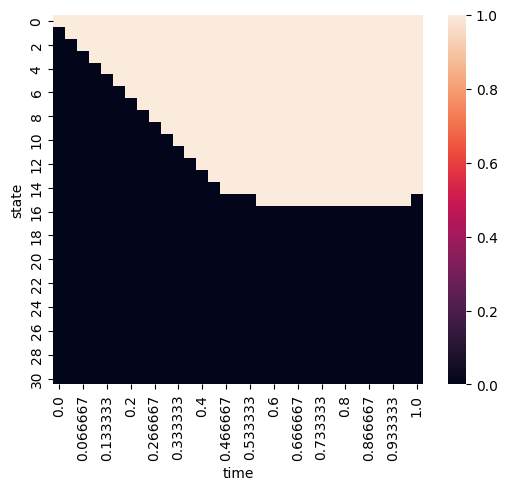

In [30]:
sns.heatmap(exercise_decisions(payoff,bondtreeT, derivtree), square=True)
plt.show()